# Handling Missing Data 

#### Types of handling misiing values- 
1. Remove Row (CCA)
2. Impute
<br>
    i. Univariate
        <ol>
        numerical(mean, random, end of list)<br>
        categorical (mode, missing)
        </ol>
    
    ii. Multivariate
        * (KNN, Iteraotr)

## 1. CCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('data/data_science_job.csv')

In [6]:
df.shape

(19158, 13)

In [2]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,52.0,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,20.0,50-99,Funded Startup,8.0,0.0


In [3]:
df.isnull().mean()*100

enrollee_id                0.000000
city                       0.000000
city_development_index     2.500261
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
training_hours             3.998330
target                     0.000000
dtype: float64

In [7]:
cols = [var for var in df.columns if df[var].isnull().mean() < 0.05 and df[var].isnull().mean() > 0]
cols

['city_development_index',
 'enrolled_university',
 'education_level',
 'experience',
 'training_hours']

In [10]:
df[cols].sample(5) # inko drop krne ka hai

,city_development_index,enrolled_university,education_level,experience,training_hours
7573,0.897,Full time course,High School,4.0,182.0
11030,0.884,no_enrollment,Phd,11.0,23.0
7203,0.920,no_enrollment,Graduate,20.0,28.0
11472,0.924,no_enrollment,Masters,20.0,11.0
17072,0.920,no_enrollment,Graduate,17.0,165.0


In [12]:
len(df[cols].dropna())/len(df)

0.8968577095730244

In [13]:
new_df = df[cols].dropna()
df.shape, new_df.shape

((19158, 13), (17182, 5))

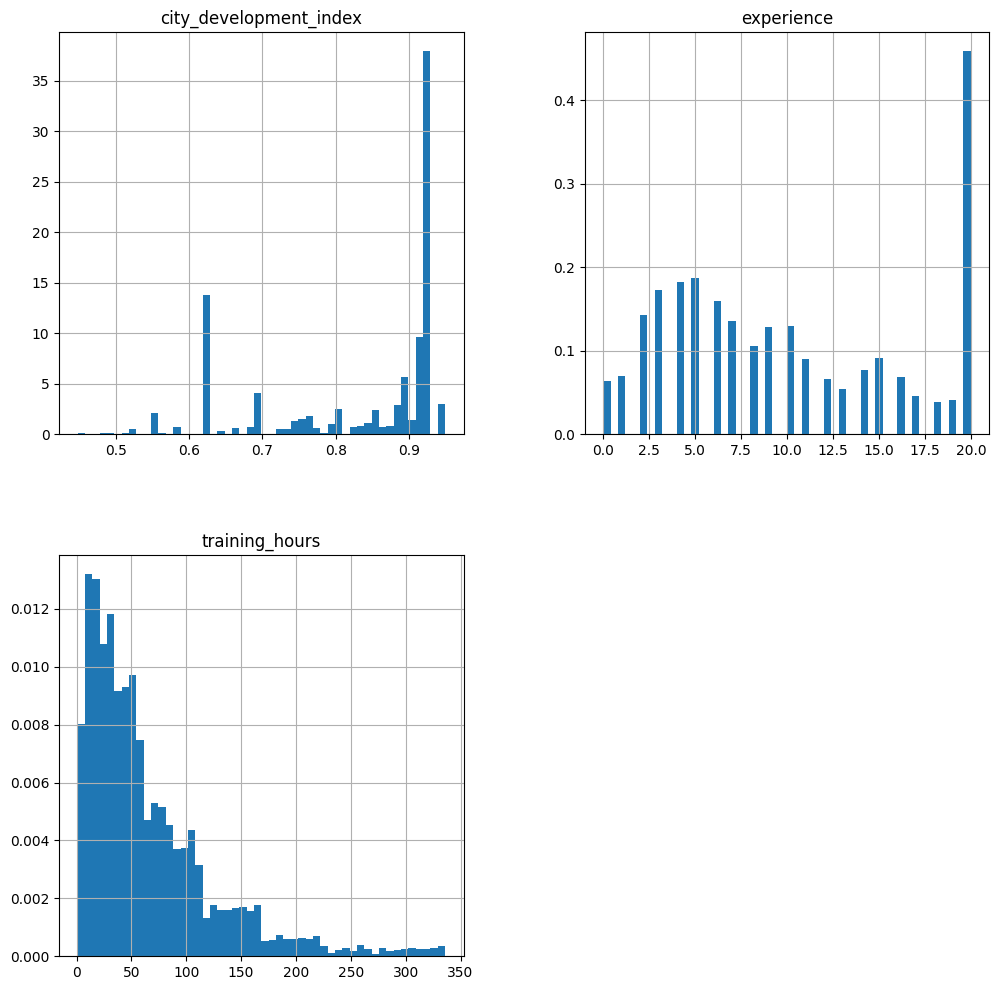

In [14]:
new_df.hist(bins=50, density=True, figsize=(12, 12))
plt.show()

<AxesSubplot:>

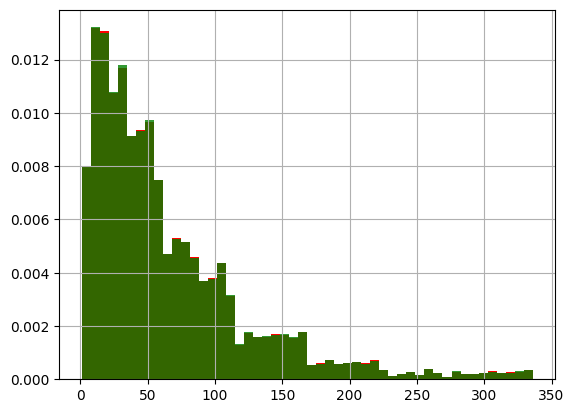

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original data
df['training_hours'].hist(bins=50, ax=ax, density=True, color='red')

# data after cca, the argument alpha makes the color transparent, so we can
# see the overlay of the 2 distributions
new_df['training_hours'].hist(bins=50, ax=ax, color='green', density=True, alpha=0.8)

In [16]:
# missing categorical variables
temp = pd.concat([
            # percentage of observations per category, original data
            df['education_level'].value_counts() / len(df),

            # percentage of observations per category, cca data
            new_df['education_level'].value_counts() / len(new_df)
        ],
        axis=1)

# add column names
temp.columns = ['original', 'cca']

temp

,original,cca
Graduate,0.605387,0.619835
Masters,0.227633,0.234082
High School,0.105282,0.107380
Phd,0.021610,0.022116
Primary School,0.016077,0.016587


## 2. Imputation

### a. Univariate Imputation - 
* Numerical data(mean/media,  end of data,   arbitrary value)
* Categorical data(Mode based, arbitrary value)
* Works on both(random, missing indiactor, gridcv search)

#### i. Mean/median imputation

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [24]:
df = pd.read_csv('data/titanic-dataset/train.csv')

In [25]:
# df = df[['Age','Fare','Sur']]

In [26]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
93,94,0,3,"Dean, Mr. Bertram Frank",male,26.0,1,2,C.A. 2315,20.5750,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S
873,874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S
309,310,1,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,PC 17485,56.9292,E36,C
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9000,NaN,S


In [27]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [28]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train.shape, X_test.shape

((712, 11), (179, 11))

In [29]:
mean_age = X_train['Age'].mean()
median_age = X_train['Age'].median()

mean_fare = X_train['Fare'].mean()
median_fare = X_train['Fare'].median()
X_train['Age_median'] = X_train['Age'].fillna(median_age)
X_train['Age_mean'] = X_train['Age'].fillna(mean_age)

X_train['Fare_median'] = X_train['Fare'].fillna(median_fare)
X_train['Fare_mean'] = X_train['Fare'].fillna(mean_fare)

In [30]:
print('Original Age variable variance: ', X_train['Age'].var())
print('Age Variance after median imputation: ', X_train['Age_median'].var())
print('Age Variance after mean imputation: ', X_train['Age_mean'].var())

print('Original Fare variable variance: ', X_train['Fare'].var())
print('Fare Variance after median imputation: ', X_train['Fare_median'].var())
print('Fare Variance after mean imputation: ', X_train['Fare_mean'].var())

Original Age variable variance:  204.34951339046142
Age Variance after median imputation:  161.98956633460548
Age Variance after mean imputation:  161.81262452718676
Original Fare variable variance:  2368.2468324201327
Fare Variance after median imputation:  2368.2468324201327
Fare Variance after mean imputation:  2368.2468324201327


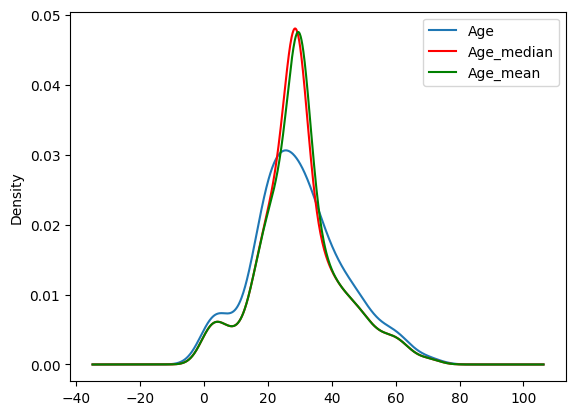

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['Age'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['Age_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['Age_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

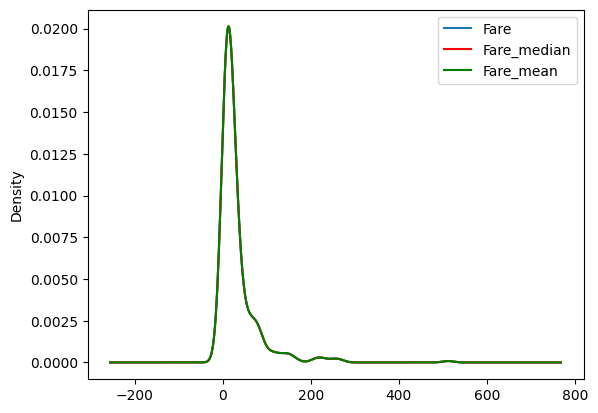

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['Fare'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['Fare_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['Fare_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

<AxesSubplot:>

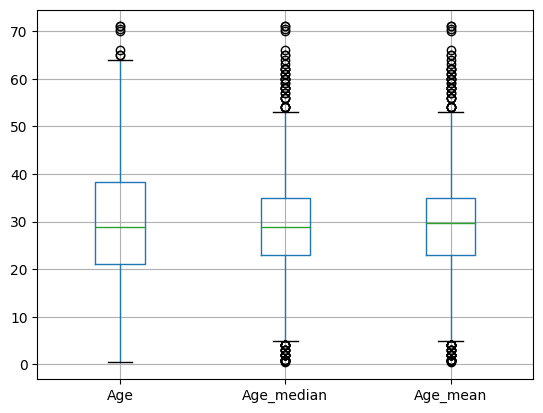

In [33]:
X_train[['Age', 'Age_median', 'Age_mean']].boxplot()

<AxesSubplot:>

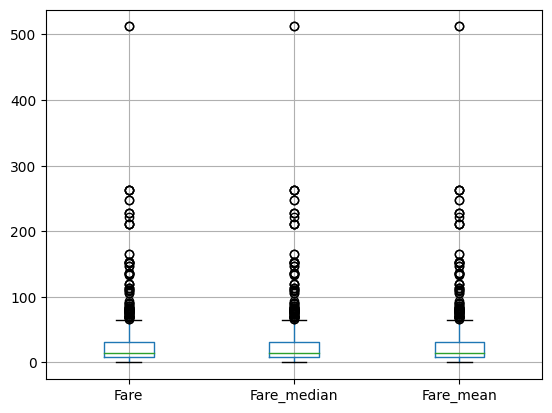

In [34]:
X_train[['Fare', 'Fare_median', 'Fare_mean']].boxplot()

_Using skelearn_

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
imputer1 = SimpleImputer(strategy='median')
imputer2 = SimpleImputer(strategy='mean')
trf = ColumnTransformer([
    ('imputer1',imputer1,['Age']),
    ('imputer2',imputer2,['Fare'])
],remainder='passthrough')
trf.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('imputer1', SimpleImputer(strategy='median'),
                                 ['Age']),
                                ('imputer2', SimpleImputer(), ['Fare'])])

In [36]:
X_train = trf.transform(X_train)
X_test = trf.transform(X_test)
X_train

array([[40.0, 27.7208, 31, ..., 'PC 17601', nan, 'C'],
       [4.0, 16.7, 11, ..., 'PP 9549', 'G6', 'S'],
       [47.0, 9.0, 874, ..., '345765', nan, 'S'],
       ...,
       [71.0, 49.5042, 494, ..., 'PC 17609', nan, 'C'],
       [28.75, 221.7792, 528, ..., 'PC 17483', 'C95', 'S'],
       [28.75, 25.925, 169, ..., 'PC 17318', nan, 'S']], dtype=object)

#### ii.  Arbitrary value insertion-

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


In [39]:
df = pd.read_csv('data/titanic-dataset/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
df.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [41]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train['Age_99'] = X_train['Age'].fillna(99)
X_train['Age_minus1'] = X_train['Age'].fillna(-1)

X_train['Fare_999'] = X_train['Fare'].fillna(999)
X_train['Fare_minus1'] = X_train['Fare'].fillna(-1)

In [42]:
print('Original Age variable variance: ', X_train['Age'].var())
print('Age Variance after 99 wala imputation: ', X_train['Age_99'].var())
print('Age Variance after -1 wala imputation: ', X_train['Age_minus1'].var())

print('Original Fare variable variance: ', X_train['Fare'].var())
print('Fare Variance after 999 wala imputation: ', X_train['Fare_999'].var())
print('Fare Variance after -1 wala imputation: ', X_train['Fare_minus1'].var())

Original Age variable variance:  204.34951339046142
Age Variance after 99 wala imputation:  951.7275570187188
Age Variance after -1 wala imputation:  318.0896202624488
Original Fare variable variance:  2368.2468324201327
Fare Variance after 999 wala imputation:  2368.2468324201327
Fare Variance after -1 wala imputation:  2368.2468324201327


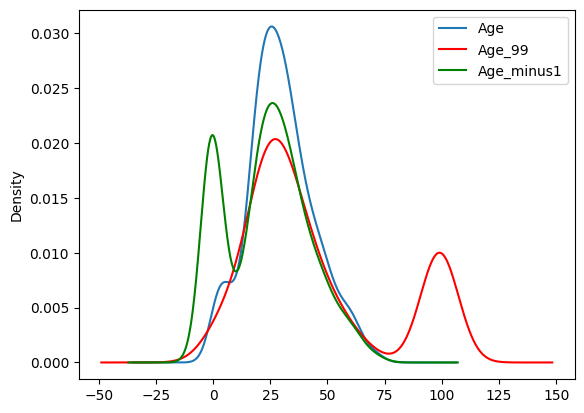

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['Age'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['Age_99'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['Age_minus1'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

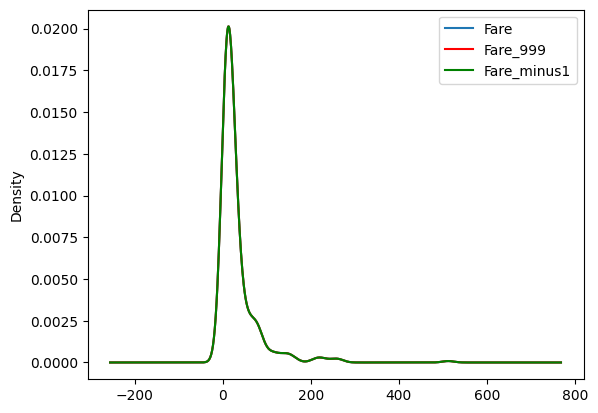

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['Fare'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['Fare_999'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['Fare_minus1'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### iii. Categorical Mode-

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('data/train.csv',usecols=['GarageQual','FireplaceQu','SalePrice'])
df.head()

,FireplaceQu,GarageQual,SalePrice
0,NaN,TA,208500
1,TA,TA,181500
2,TA,TA,223500
3,Gd,TA,140000
4,TA,TA,250000


In [47]:
df.isnull().mean()*100

FireplaceQu    47.260274
GarageQual      5.547945
SalePrice       0.000000
dtype: float64

<AxesSubplot:>

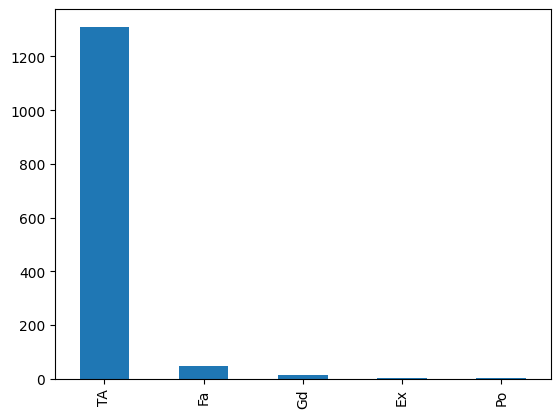

In [48]:
df['GarageQual'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'GarageQual')

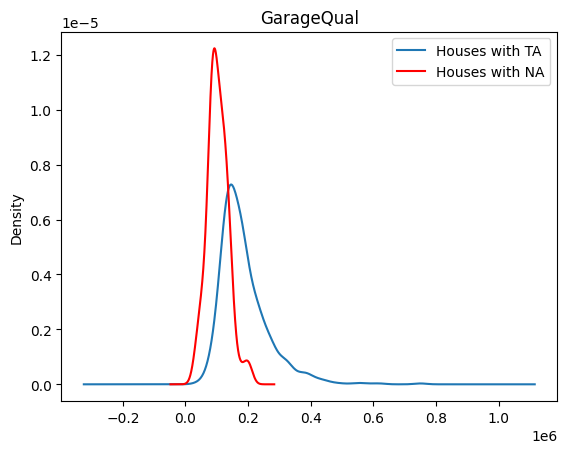

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)

df[df['GarageQual']=='TA']['SalePrice'].plot(kind='kde', ax=ax)

df[df['GarageQual'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
labels = ['Houses with TA', 'Houses with NA']
ax.legend(lines, labels, loc='best')

plt.title('GarageQual')

<AxesSubplot:>

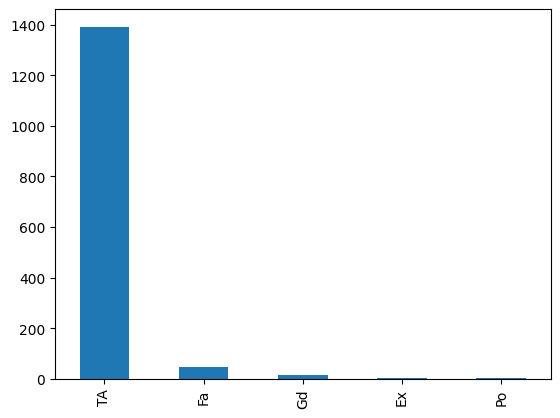

In [50]:
temp = df[df['GarageQual']=='TA']['SalePrice']
df['GarageQual'].fillna('TA', inplace=True)
df['GarageQual'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'GarageQual')

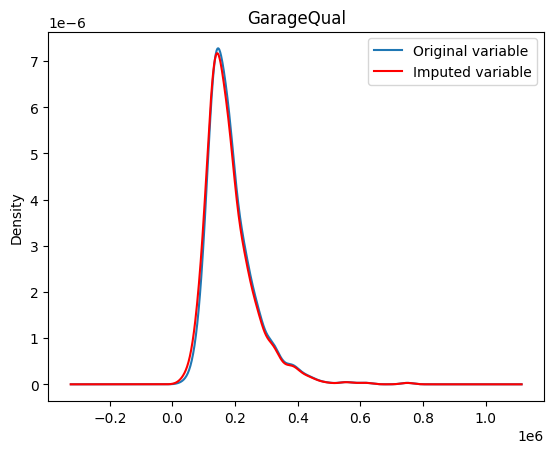

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)


temp.plot(kind='kde', ax=ax)

# distribution of the variable after imputation
df[df['GarageQual'] == 'TA']['SalePrice'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

# add title
plt.title('GarageQual')

0    Gd
dtype: object

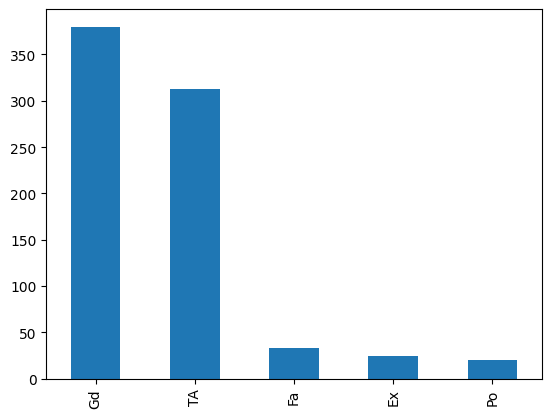

In [52]:
df['FireplaceQu'].value_counts().plot(kind='bar')
df['FireplaceQu'].mode()

Text(0.5, 1.0, 'FireplaceQu')

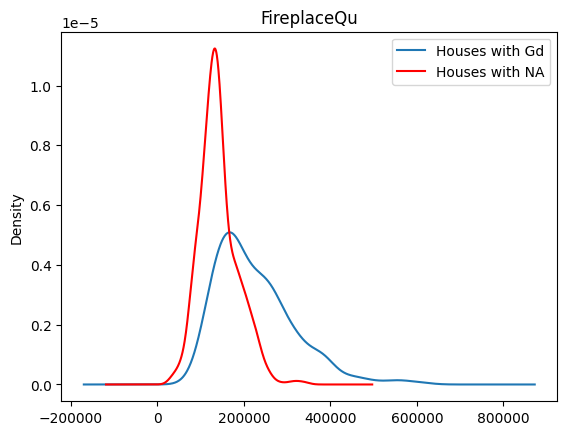

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)

df[df['FireplaceQu']=='Gd']['SalePrice'].plot(kind='kde', ax=ax)

df[df['FireplaceQu'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
labels = ['Houses with Gd', 'Houses with NA']
ax.legend(lines, labels, loc='best')

plt.title('FireplaceQu')

<AxesSubplot:>

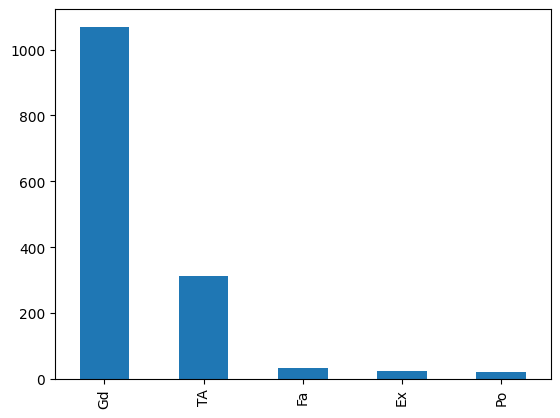

In [54]:
temp = df[df['FireplaceQu']=='Gd']['SalePrice']
df['FireplaceQu'].fillna('Gd', inplace=True)
df['FireplaceQu'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'FireplaceQu')

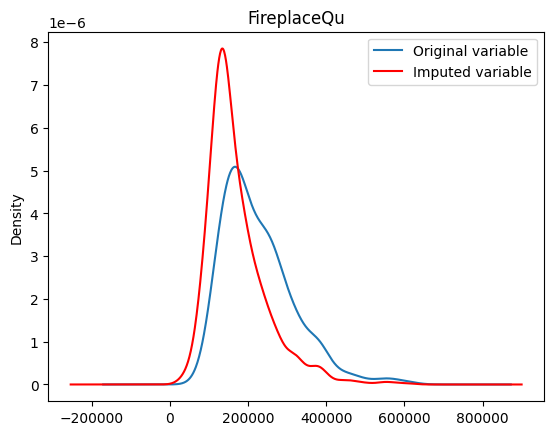

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)


temp.plot(kind='kde', ax=ax)

# distribution of the variable after imputation
df[df['FireplaceQu'] == 'Gd']['SalePrice'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

# add title
plt.title('FireplaceQu')

#### iv. Categorical arbitrary imputation-

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('data/train.csv',usecols=['GarageQual','FireplaceQu','SalePrice'])
df.head()

,FireplaceQu,GarageQual,SalePrice
0,NaN,TA,208500
1,TA,TA,181500
2,TA,TA,223500
3,Gd,TA,140000
4,TA,TA,250000


In [57]:
df.isnull().mean()*100

FireplaceQu    47.260274
GarageQual      5.547945
SalePrice       0.000000
dtype: float64

Text(0, 0.5, 'Number of houses')

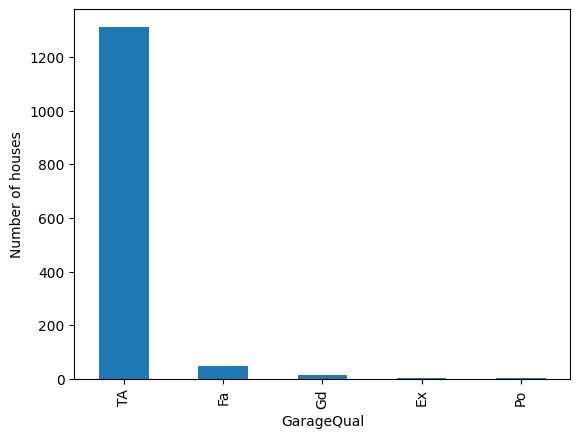

In [58]:
df['GarageQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('GarageQual')
plt.ylabel('Number of houses')

Text(0, 0.5, 'Number of houses')

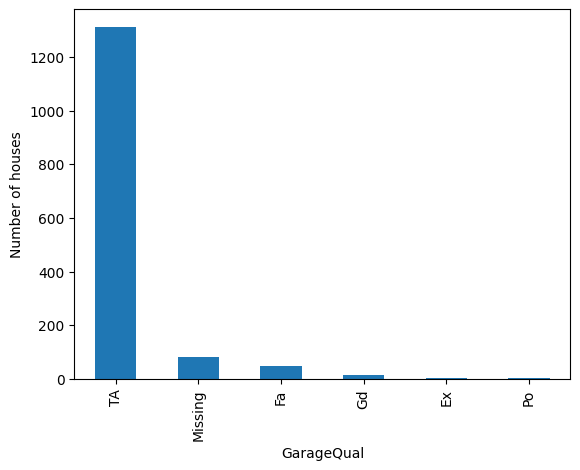

In [59]:
df['GarageQual'].fillna('Missing', inplace=True)
df['GarageQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('GarageQual')
plt.ylabel('Number of houses')

In [60]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['SalePrice']),df['SalePrice'],test_size=0.2)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant',fill_value='Missing')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_train)
imputer.statistics_

c:\Users\HP\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  "X does not have valid feature names, but"


array(['Missing', 'Missing'], dtype=object)

#### v. Random imputation-

In [63]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('data/titanic-dataset/train.csv',usecols=['Age','Fare','Survived'])
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [65]:
df.isnull().mean() * 100

Survived     0.00000
Age         19.86532
Fare         0.00000
dtype: float64

In [64]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train

,Age,Fare
30,40.0,27.7208
10,4.0,16.7000
873,47.0,9.0000
182,9.0,31.3875
876,20.0,9.8458
...,...,...
534,30.0,8.6625
584,NaN,8.7125
493,71.0,49.5042
527,NaN,221.7792


In [66]:
X_train['Age_imputed'] = X_train['Age']
X_test['Age_imputed'] = X_test['Age']

In [67]:
X_train['Age_imputed'][X_train['Age_imputed'].isnull()] = X_train['Age'].dropna().sample(X_train['Age'].isnull().sum()).values
X_test['Age_imputed'][X_test['Age_imputed'].isnull()] = X_train['Age'].dropna().sample(X_test['Age'].isnull().sum()).values

In [68]:
X_train['Age'].dropna().sample(X_train['Age'].isnull().sum()).values

array([62.  , 35.  , 30.  , 21.  , 50.  , 20.  ,  4.  , 54.  , 24.  ,
       24.  , 27.  , 36.  , 32.  , 24.  , 20.  , 16.  , 46.  , 61.  ,
       26.  , 28.  , 33.  , 35.  , 38.  , 24.  , 28.  , 52.  , 45.  ,
       37.  ,  9.  , 30.  , 58.  ,  8.  , 16.  , 30.  , 22.  , 35.  ,
       65.  , 26.  , 10.  , 36.  , 25.  , 40.  , 21.  , 39.  , 50.  ,
       27.  , 32.  , 33.  , 25.  , 22.  , 27.  , 19.  , 33.  , 25.  ,
       34.  , 19.  , 36.  , 42.  , 20.  , 34.  , 16.  ,  1.  , 27.  ,
       44.  , 25.  , 47.  ,  0.83, 14.  , 24.  , 36.  , 21.  , 39.  ,
       24.  , 35.  , 32.  , 18.  , 48.  , 29.  ,  0.83, 20.  , 34.  ,
       49.  , 18.  , 18.  , 34.  , 40.5 , 36.  , 33.  , 35.  , 22.  ,
       33.  , 24.  , 29.  , 39.  , 30.  ,  5.  , 31.  , 50.  , 23.  ,
       20.  , 25.  ,  4.  , 40.  , 19.  , 22.  , 19.  , 17.  , 56.  ,
       33.  , 17.  , 34.  , 41.  ,  9.  , 32.  , 28.  , 31.  , 56.  ,
       36.  , 14.  , 47.  , 30.  , 28.  , 36.  , 47.  ,  2.  , 27.  ,
       23.  , 44.  ,

In [70]:
X_train['Age'].isnull().sum()

148

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



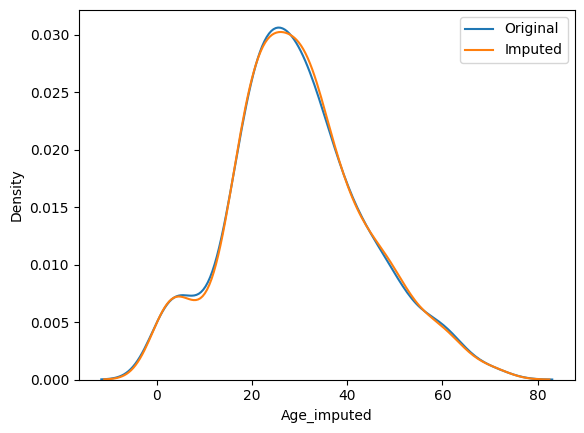

In [71]:
sns.distplot(X_train['Age'],label='Original',hist=False)
sns.distplot(X_train['Age_imputed'],label = 'Imputed',hist=False)

plt.legend()
plt.show()

In [72]:
X_train[['Fare', 'Age', 'Age_imputed']].cov()

,Fare,Age,Age_imputed
Fare,2368.246832,71.512440,42.162472
Age,71.512440,204.349513,204.349513
Age_imputed,42.162472,204.349513,202.560314


#### vi. Missing indicator-

In [73]:
# can add missing indicator ..... which is sometimes shown to increase the value of accuracy

#### vii. Grid Search CV -

In [87]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('data/titanic-dataset/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
df.drop(columns=['PassengerId','Name','Ticket','Cabin'],inplace=True)

In [89]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
30,1,male,40.0,0,0,27.7208,C
10,3,female,4.0,1,1,16.7000,S
873,3,male,47.0,0,0,9.0000,S
182,3,male,9.0,4,2,31.3875,S
876,3,male,20.0,0,0,9.8458,S


In [90]:
numerical_features = ['Age', 'Fare']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Embarked', 'Sex']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
])

In [91]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [92]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [93]:
from sklearn import set_config

set_config(display='diagram')
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex'])])),
                ('classifier', LogisticRegression())])

In [94]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
    'classifier__C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(clf, param_grid, cv=10)


In [95]:
grid_search.fit(X_train, y_train)

print(f"Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__C': 1.0, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}


In [96]:
print(f"Internal CV score: {grid_search.best_score_:.3f}")

Internal CV score: 0.788


In [97]:
import pandas as pd

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[['param_classifier__C','param_preprocessor__cat__imputer__strategy','param_preprocessor__num__imputer__strategy','mean_test_score']]

,param_classifier__C,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer__strategy,mean_test_score
4,1.0,most_frequent,mean,0.787852
5,1.0,most_frequent,median,0.787852
6,1.0,constant,mean,0.787852
7,1.0,constant,median,0.787852
8,10,most_frequent,mean,0.787852
9,10,most_frequent,median,0.787852
10,10,constant,mean,0.787852
11,10,constant,median,0.787852
12,100,most_frequent,mean,0.787852
13,100,most_frequent,median,0.787852


### b. Multivariate Imputation-
* knn-imputer
* iterative imputer

#### i. knn-imputer
    

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('data/titanic-dataset/train.csv')[['Age','Pclass','Fare','Survived']]
df.head()

,Age,Pclass,Fare,Survived
0,22.0,3,7.2500,0
1,38.0,1,71.2833,1
2,26.0,3,7.9250,1
3,35.0,1,53.1000,1
4,35.0,3,8.0500,0


In [3]:
df.isnull().mean() * 100

Age         19.86532
Pclass       0.00000
Fare         0.00000
Survived     0.00000
dtype: float64

In [4]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train.head()

,Age,Pclass,Fare
30,40.0,1,27.7208
10,4.0,3,16.7000
873,47.0,3,9.0000
182,9.0,3,31.3875
876,20.0,3,9.8458


In [25]:
knn = KNNImputer(n_neighbors=3,weights='distance')

X_train_trf = knn.fit_transform(X_train)
X_test_trf = knn.transform(X_test)


In [26]:
lr = LogisticRegression()

lr.fit(X_train_trf,y_train)

y_pred = lr.predict(X_test_trf)

accuracy_score(y_test,y_pred)

0.7150837988826816

In [27]:
si = SimpleImputer()

X_train_trf2 = si.fit_transform(X_train)
X_test_trf2 = si.transform(X_test)
lr = LogisticRegression()

lr.fit(X_train_trf2,y_train)

y_pred2 = lr.predict(X_test_trf2)

accuracy_score(y_test,y_pred2)

0.6927374301675978

#### ii. iterative imputer(mice)-

##### https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html